# Comparative Analysis of Thyroid Disease Classification Models

**Author:** Ashutosh Shirsat  
**Project:** Data Science/ML   
**Objective:** Compare and evaluate three different models, namely Generalized Linear Model (GLM), Support Vector Machines (SVM), Random Forest (RF) and K-Nearest Neighbour (KNN) to determine the most suitable model for accurate predictions on this dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

1. Load and Prepare Data
Purpose: Read the data, identify numeric and categorical features, set up target variable.

In [2]:
# 1. Load your data
data = pd.read_csv("data/thyroidData_Lasso_featureselected.csv")
target_col = 'thyroid'
X = data.drop(columns=target_col)
y = data[target_col].astype(int)

# 2. Identify feature types
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()

2. Train/Test Split
Purpose: Split data so model evaluation is honest.

In [3]:
# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123456
)

3. Preprocessing Pipeline
Purpose: One-hot encode categoricals, scale numerics.

In [4]:
# 4. Preprocessing Pipeline
numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

4. Model Pipelines and Hyperparameter Grids
Purpose: Define models and tuning options, all within pipelines.

In [5]:
# 5. Define all models, parameter grids, and a results placeholder in one dictionary
models = {
    "GLM": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(solver='lbfgs', max_iter=2000, random_state=123456))
        ]),
        "param_grid": {
            "classifier__C": np.logspace(-3, 2, 10)
        },
        "results": {}
    },
    "SVM": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", SVC(probability=True, kernel="rbf", random_state=123456))
        ]),
        "param_grid": {
            "classifier__C": [0.25, 1, 1.5, 2, 5],
            "classifier__gamma": [0, 0.5, 1.5]
        },
        "results": {}
    },
    "RandomForest": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(n_estimators=600, random_state=123456))
        ]),
        "param_grid": {
            "classifier__max_features": ["sqrt", "log2", None]
        },
        "results": {}
    },
    "KNN": {
        "estimator": Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", KNeighborsClassifier())
        ]),
        "param_grid": {
            "classifier__n_neighbors": [3, 5, 7, 9, 11],
            "classifier__weights": ["uniform", "distance"]
        },
        "results": {}
    }
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123456)

5. Model Selection and Hyperparameter Tuning
Purpose: Use cross-validation for model selection and tuning.

In [6]:
# 6. Training, tuning, storing results, and feature importance
for name, model in models.items():
    print(f"\n==== {name} ====")
    grid = GridSearchCV(model["estimator"], model["param_grid"], cv=cv, scoring="roc_auc", n_jobs=-1, return_train_score=True)
    grid.fit(X_train, y_train)
    model["grid"] = grid  # store fitted GridSearchCV
    model["results"]["best_params"] = grid.best_params_
    model["results"]["best_cv_auc"] = grid.best_score_
    print("Best params:", grid.best_params_)
    print("Best CV ROC-AUC:", grid.best_score_)

    # Test set evaluation
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:,1]
    model["results"]["test_auc"] = roc_auc_score(y_test, y_proba)
    model["results"]["test_accuracy"] = accuracy_score(y_test, y_pred)
    model["results"]["test_precision"] = precision_score(y_test, y_pred)
    model["results"]["test_recall"] = recall_score(y_test, y_pred)
    model["results"]["test_f1"] = f1_score(y_test, y_pred)
    model["results"]["confusion_matrix"] = confusion_matrix(y_test, y_pred)
    print("Test set AUC:", model["results"]["test_auc"])

    # Store cross-val AUCs for boxplot
    model["results"]["cv_aucs"] = cross_val_score(grid.best_estimator_, X_train, y_train, cv=cv, scoring="roc_auc")
    print("Cross-validated AUCs:", model["results"]["cv_aucs"])

    # Feature importance for GLM and RF
    if name == "GLM":
        coef = grid.best_estimator_.named_steps['classifier'].coef_[0]
        ohe = grid.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(categorical_features) if categorical_features else []
        all_feature_names = numeric_features + list(cat_names)
        importance = pd.DataFrame({"feature": all_feature_names, "coefficient": coef})
        importance['abs_coef'] = importance['coefficient'].abs()
        importance = importance.sort_values('abs_coef', ascending=False)
        print("\nTop GLM Features by absolute coefficient:\n", importance.head(10))
        model["results"]["feature_importance"] = importance

    if name == "RandomForest":
        importances = grid.best_estimator_.named_steps['classifier'].feature_importances_
        ohe = grid.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(categorical_features) if categorical_features else []
        all_feature_names = numeric_features + list(cat_names)
        importance = pd.DataFrame({"feature": all_feature_names, "importance": importances})
        importance = importance.sort_values('importance', ascending=False)
        print("\nTop RF Features by importance:\n", importance.head(10))
        model["results"]["feature_importance"] = importance



==== GLM ====
Best params: {'classifier__C': np.float64(0.046415888336127795)}
Best CV ROC-AUC: 0.9652584852815002
Test set AUC: 0.9779649595687332
Cross-validated AUCs: [0.9640877  0.95609224 0.96903442 0.97208852 0.96498956]

Top GLM Features by absolute coefficient:
                   feature  coefficient  abs_coef
10                    TSH     1.934233  1.934233
3            on_thyroxine    -0.842847  0.842847
2                      T3     0.705797  0.705797
8         thyroid_surgery    -0.504039  0.504039
4                     FTI     0.311333  0.311333
11     query_hyperthyroid     0.268065  0.268065
16  referral_source_other     0.246281  0.246281
9                     T4U    -0.226712  0.226712
13   referral_source_SVHC    -0.182703  0.182703
15    referral_source_SVI    -0.163649  0.163649

==== SVM ====
Best params: {'classifier__C': 1, 'classifier__gamma': 0.5}
Best CV ROC-AUC: 0.982835614711334
Test set AUC: 0.9867828263380825
Cross-validated AUCs: [0.98989733 0.97656659 0

6. Model Evaluation and Visualization
Purpose: ROC curves, metrics, confusion matrix, learning curves.

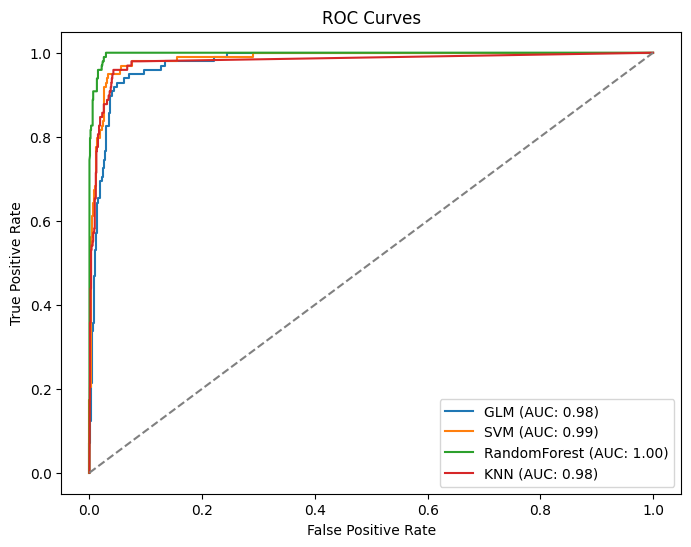

In [7]:
# 7. Compare and visualize results

# ROC curves for all models
plt.figure(figsize=(8,6))
for name, model in models.items():
    grid = model["grid"]
    y_proba = grid.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC: {auc:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


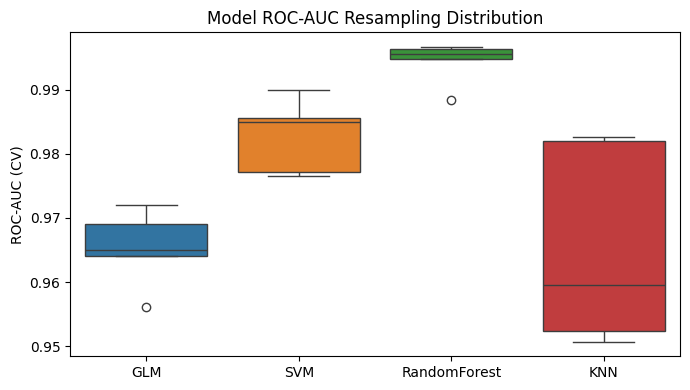

In [8]:
# Boxplot of CV AUCs
cv_auc_dict = {name: model["results"]["cv_aucs"] for name, model in models.items() if "cv_aucs" in model["results"]}
cv_auc_df = pd.DataFrame(cv_auc_dict)
plt.figure(figsize=(7,4))
sns.boxplot(data=cv_auc_df)
plt.ylabel("ROC-AUC (CV)")
plt.title("Model ROC-AUC Resampling Distribution")
plt.tight_layout()
plt.show()

In [9]:

# Show confusion matrix for each model
for name, model in models.items():
    print(f"\n{name} Confusion Matrix:\n", model["results"]["confusion_matrix"])


GLM Confusion Matrix:
 [[1049   11]
 [  48   50]]

SVM Confusion Matrix:
 [[1053    7]
 [  38   60]]

RandomForest Confusion Matrix:
 [[1050   10]
 [   9   89]]

KNN Confusion Matrix:
 [[1048   12]
 [  33   65]]


In [10]:
# Metrics DataFrame for summary
metrics = []
for name, model in models.items():
    r = model["results"]
    metrics.append({
        "Model": name,
        "Test AUC": r["test_auc"],
        "Accuracy": r["test_accuracy"],
        "Precision": r["test_precision"],
        "Recall": r["test_recall"],
        "F1": r["test_f1"]
    })
summary = pd.DataFrame(metrics)
print("\nModel Performance Metrics:\n", summary)


Model Performance Metrics:
           Model  Test AUC  Accuracy  Precision    Recall        F1
0           GLM  0.977965  0.949050   0.819672  0.510204  0.628931
1           SVM  0.986783  0.961140   0.895522  0.612245  0.727273
2  RandomForest  0.997680  0.983592   0.898990  0.908163  0.903553
3           KNN  0.979337  0.961140   0.844156  0.663265  0.742857


## Conclusion : 
**Best Model**
- Random Forest is the best performing model on this dataset, achieving the highest test set ROC-AUC (0.9976), accuracy (0.98), precision (0.90), recall (0.91), and F1 score (0.90).
- SVM and KNN also performed well (AUCs ≈ 0.98–0.99), but consistently below Random Forest.
- GLM (Logistic Regression) was outperformed by the others, especially in recall and F1-score (0.51 and 0.63, respectively).

**Rationale for Random Forest Superiority**
- Ensemble learning: RF combines multiple trees and naturally handles feature interactions and non-linearities, which are common in medical data.
- Balanced Performance: RF achieved a perfect balance of high precision (low false positives), high recall (low false negatives), and thus the highest F1-score.
- Generalization: The cross-validated AUCs are consistently high (≈0.99+), indicating robustness and low overfitting.

**Key Feature for Thyroid Disease Prediction**
Top predictor (from GLM and RF): TSH (Thyroid Stimulating Hormone). This feature was selected by LASSO regularization and/or ranked highly in feature importance.

